

# DAP05 - Final Project



Larissa Magalhaes - derezendemagalhaes@uni-potsdam.de

---



## Pixel and Image Classification on a Sentinel-2 Time Series



**(a)** Select a geographic area of interest (not Golm, each student select a different region) and download three (3) Sentinel-2 Level1C images separated by at least one year each using Google Earth Engine in Python.

In [1]:
import ee

# ee.Authenticate()
ee.Initialize()

Download the imagery using GEE, the selected region was Varginha (MG) in southeast of Brazil. This is a medium size city with a population of 136 thousand (2020). The main focus is to observe the urban development around the city over the last three years (2018-2020).

In [2]:
# Define variables to download the imagery
collection = 'COPERNICUS/S2'
area_name = 'varginha' # Varginha, Minas Gerais - Brazil
drive_folder = 'varginha_sentinel2_level1C'

# Define time range for the 3 images
time_range_1 = ['2020-05-01', '2020-06-01']
time_range_2 = ['2019-05-01', '2019-06-01']
time_range_3 = ['2018-05-01', '2018-06-01']

# Defined very low cloud percentage to garantee an image cloud-free:
max_cloud_percent = 1

# Selected bands for output raster
band_list = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']
spatial_resolution = 10

# Coordinates of bounding box for selected region of Varginha, Brazil.
bbox_coords = [-45.476406,-21.565619,-45.443921,-21.538263]


Create AOI using defined bounding box. Then access earth engine's image collection, filter the bound of our AOI, filter the date and also the maximum cloudy pixel percentage. And finally select only the first returned image:

In [3]:
AOI = ee.Geometry.Rectangle(bbox_coords)
image_collection_1 = ee.ImageCollection(collection).filterBounds(AOI).\
                    filterDate(time_range_1[0], time_range_1[1]).\
                    filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', max_cloud_percent))
image_collection_2 = ee.ImageCollection(collection).filterBounds(AOI).\
                    filterDate(time_range_2[0], time_range_2[1]).\
                    filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', max_cloud_percent))
image_collection_3 = ee.ImageCollection(collection).filterBounds(AOI).\
                    filterDate(time_range_3[0], time_range_3[1]).\
                    filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', max_cloud_percent))

first_img = image_collection_1.first()
second_img = image_collection_2.first()
third_img = image_collection_3.first()

Define filename for the downloaded images:

In [4]:
filename_1 ='01_' + first_img.getInfo()['properties']['PRODUCT_ID'] + '_' + area_name + '_stacked_rescaled'
filename_2 ='02_' + second_img.getInfo()['properties']['PRODUCT_ID'] + '_' + area_name + '_stacked_rescaled'
filename_3 ='03_' + third_img.getInfo()['properties']['PRODUCT_ID'] + '_' + area_name + '_stacked_rescaled'

print(filename_1)
print(filename_2)
print(filename_3)

01_S2B_MSIL1C_20200501T131239_N0209_R138_T23KMS_20200501T144404_varginha_stacked_rescaled
02_S2B_MSIL1C_20190527T131249_N0207_R138_T23KMS_20190527T135301_varginha_stacked_rescaled
03_S2B_MSIL1C_20180502T131239_N0206_R138_T23KMS_20180502T135204_varginha_stacked_rescaled


Export images to drive as a batch, saving it on a specified folder:

In [5]:
export_job_1 = ee.batch.Export.image.toDrive(
                first_img.select(band_list).divide(10000), #scale 0.0001 GEE
                description = filename_1,
                folder = drive_folder,
                region = AOI.getInfo()['coordinates'],
                scale = spatial_resolution)

export_job_2 = ee.batch.Export.image.toDrive(
                second_img.select(band_list).divide(10000), #scale 0.0001 GEE
                description = filename_2,
                folder = drive_folder,
                region = AOI.getInfo()['coordinates'],
                scale = spatial_resolution)

export_job_3 = ee.batch.Export.image.toDrive(
                third_img.select(band_list).divide(10000), #scale 0.0001 GEE
                description = filename_3,
                folder = drive_folder,
                region = AOI.getInfo()['coordinates'],
                scale = spatial_resolution)

Now, the next lines will start the defined jobs:

In [6]:
export_job_1.start()
export_job_2.start()
export_job_3.start()

After a few minutes the images were already available in my personal google Drive.

---

**(b)** Create separate label shapefiles for each of the three images in your favorite GIS (may I suggest QGIS?). Use at least 5 label classes of your choosing (e.g., forest, desert, snow, buildings, roads, etc.). This depends on the content of your chosen geographic area! The classes should be the same between the different scenes.

In [1]:
# Import modules
import numpy as np
import rasterio
from rasterio.mask import mask
import geopandas as gpd
from shapely.geometry import mapping
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd 

# Plot inline
%matplotlib inline


Load labels and sentinel images:

In [2]:
label_01 = '01_varginha_labels.shp'
label_02 = '02_varginha_labels.shp'
label_03 = '03_varginha_labels.shp'

sentinel_01 = '01_S2B_MSIL1C_20200501T131239_N0209_R138_T23KMS_20200501T144404_varginha_stacked_rescaled.tif'
sentinel_02 = '02_S2B_MSIL1C_20190527T131249_N0207_R138_T23KMS_20190527T135301_varginha_stacked_rescaled.tif'
sentinel_03 = '03_S2B_MSIL1C_20180502T131239_N0206_R138_T23KMS_20180502T135204_varginha_stacked_rescaled.tif'


Rescale the range 0-0.275 in our first three bands to 8-bit 1-255 (reserving 0 for no data values), using gdal:

In [3]:
!gdal_translate -of JPEG -co QUALITY=100 \
    -ot Byte -a_nodata 0 -scale 0 0.275 1 255 \
    -b 3 -b 2 -b 1 -of JPEG \
    01_S2B_MSIL1C_20200501T131239_N0209_R138_T23KMS_20200501T144404_varginha_stacked_rescaled.tif \
    01_sentinel_varginha_2020_rgb_8bit.jpg

!gdal_translate -of JPEG -co QUALITY=100 \
    -ot Byte -a_nodata 0 -scale 0 0.275 1 255 \
    -b 3 -b 2 -b 1 -of JPEG \
    02_S2B_MSIL1C_20190527T131249_N0207_R138_T23KMS_20190527T135301_varginha_stacked_rescaled.tif \
    02_sentinel_varginha_2019_rgb_8bit.jpg

!gdal_translate -of JPEG -co QUALITY=100 \
    -ot Byte -a_nodata 0 -scale 0 0.275 1 255 \
    -b 3 -b 2 -b 1 -of JPEG \
    03_S2B_MSIL1C_20180502T131239_N0206_R138_T23KMS_20180502T135204_varginha_stacked_rescaled.tif \
    03_sentinel_varginha_2018_rgb_8bit.jpg

Input file size is 338, 305
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 338, 305
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 338, 305
0...10...20...30...40...50...60...70...80...90...100 - done.


Defined a function to run the pre-processing of the labels, based on code provided in class:

In [3]:
def pre_processing(sentinel_fp, label_fp):
    
    ''' 
        Inputs:
        sentinel_fp = the imagery filepath in which the model will be trained on.
        label_fp = the labels for the same planet imagery in order to train the classification.
        date = date of the planet image
        AOI = area of interest of the image
        
        This function will load the labels, check the projection and put the data in the same projection as the labels,
        generate a list of shapely geometries, transform the GeoJSON format using rasterio and pull out the pixel values
        using a mask in order to finally loop over the geometries and get the raster pixel values within the geometries.
        
        Outputs:
        X_reshape and y. Which consist of the pixel values and the associated class 
        of each pixel, respectively.
        
    '''
    # Load the scene and print the metadata:
    full_dataset = rasterio.open(sentinel_fp)
    meta = (full_dataset.meta)
    
    # Assign the number of bands to a variable:
    n_bands = full_dataset.count
    
    # Check the projection of the data:
    project_to = full_dataset.crs.to_dict()['init']
    # Now load the shapefile using geopandas and check it's projection:
    shapefile = gpd.read_file(label_fp)
    # Use geopandas to put the data in the same projection:
    shapefile = shapefile.to_crs(project_to)
    
    # This generates a list of shapely geometries:
    geoms = shapefile.geometry.values 
    geometry = geoms[2] 
    classname = shapefile['classname'][2]
    
    # Transform to GeoJSON format using rasterio 'mapping' function:
    feature = [mapping(geometry)]

    # Pull out the the pixel values with mask:
    out_image = mask(full_dataset, feature, crop=True, filled=True)[0]
    
    # Loop over all polygons in the training labels to form our samples from the raster:
    X = np.array([], dtype=np.float32).reshape(n_bands, -1)
    # Labels for training:
    y = np.array([], dtype=np.string_)
    
    # Loop over geometries:
    for index, geom in enumerate(geoms):
        # Get current polygon
        feature = [mapping(geom)]
        # Get the classname for the polygon:
        classname = shapefile['classname'][index]
        # The mask function returns an array of the raster pixels within this polygon:
        out_image = mask(full_dataset, feature, nodata=0, crop=True)[0]
        # Eliminate all the pixels with 0 values for all bands - AKA not actually part of the shapefile:
        out_image = out_image[:, ~np.all(out_image == 0, axis=0)]
        # Append the labels to the y array:
        y = np.append(y, [classname] * out_image.shape[1]) 
        # Stack the pixels onto the pixel array:
        X = np.hstack((X, out_image))
        
    # Define classification labels:
    labels = np.unique(shapefile['classname'])
    
    # Now we save out the X (pixel bands) and y (pixel classes)    
    # Reshape the X array for passing to classifiers
    X_reshape = X.T
    
    return X_reshape, y, labels


Apply pre_processing function in sentiinel images for 2020, 2019 and 2018, respectively.

In [4]:
X_01, y_01, labels_01 = pre_processing(sentinel_01, label_01)

X_02, y_02, labels_02 = pre_processing(sentinel_02, label_02)

X_03, y_03, labels_03 = pre_processing(sentinel_03, label_03)


Check labels for the 3 images, they should be the same:

In [5]:
print(labels_01)
print(labels_02)
print(labels_03)

['dirt' 'farm' 'forest' 'roofblue' 'roofred' 'roofwhite' 'sealedRoad']
['dirt' 'farm' 'forest' 'roofblue' 'roofred' 'roofwhite' 'sealedRoad']
['dirt' 'farm' 'forest' 'roofblue' 'roofred' 'roofwhite' 'sealedRoad']


Now save the pixel values for each Sentinel image, and the associated class of each pixel:

In [6]:
with open('01_pixel_bands_2020.npy', 'wb') as f:
    np.save(f, X_01)
    
with open('02_pixel_bands_2019.npy', 'wb') as f:
    np.save(f, X_02)
    
with open('03_pixel_bands_2018.npy', 'wb') as f:
    np.save(f, X_03)

with open('01_pixel_band_classes_2020.npy', 'wb') as f:
    np.save(f, y_01)
    
with open('02_pixel_band_classes_2019.npy', 'wb') as f:
    np.save(f, y_02)
    
with open('03_pixel_band_classes_2018.npy', 'wb') as f:
    np.save(f, y_03)

**(c)** For each scene: use the training data you created to train a few ML models of your choice (at least 3 different models). Estimate the accuracy of your models via cross-validation. For at least one of the models you've trained, do a hyperparameter tuning, and report the accuracy computed via nested cross-validation.

In [1]:
import os
import matplotlib as mpl
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
import warnings
warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (12, 5)
mpl.rcParams['figure.dpi']= 300

from sklearn.preprocessing import StandardScaler, QuantileTransformer, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedShuffleSplit, StratifiedKFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier

Defining file paths and loading the sentinel and rgb images:

In [2]:
# File path to the rgb image for visualization:
rgb_fp_01 =  '01_sentinel_varginha_2020_rgb_8bit.jpg'
rgb_fp_02 =  '02_sentinel_varginha_2019_rgb_8bit.jpg'
rgb_fp_03 =  '03_sentinel_varginha_2018_rgb_8bit.jpg'

# Load original tiff file:
sentinel_01 = '01_S2B_MSIL1C_20200501T131239_N0209_R138_T23KMS_20200501T144404_varginha_stacked_rescaled.tif'
sentinel_02 = '02_S2B_MSIL1C_20190527T131249_N0207_R138_T23KMS_20190527T135301_varginha_stacked_rescaled.tif'
sentinel_03 = '03_S2B_MSIL1C_20180502T131239_N0206_R138_T23KMS_20180502T135204_varginha_stacked_rescaled.tif'

full_dataset_01 = rasterio.open(sentinel_01)
full_dataset_02 = rasterio.open(sentinel_02)
full_dataset_03 = rasterio.open(sentinel_03)

# Save metadata: 
meta = full_dataset_01.meta

# Save width and height for later reshaping, since the 3 images have the same height and 
# width there is no need to save for all of them
width = full_dataset_01.meta['width']
height = full_dataset_01.meta['height']


In [3]:
# Load training data:
X_01 = np.load('01_pixel_bands_2020.npy')
y_01 = np.load('01_pixel_band_classes_2020.npy')
X_02 = np.load('02_pixel_bands_2019.npy')
y_02 = np.load('02_pixel_band_classes_2019.npy')
X_03 = np.load('03_pixel_bands_2018.npy')
y_03 = np.load('03_pixel_band_classes_2018.npy')

# Load prediction image:
X_pred_01 = full_dataset_01.read()
X_pred_02 = full_dataset_02.read()
X_pred_03 = full_dataset_03.read()

# Adjust the axis to move band axis to the last dimension:
X_pred_01 = np.moveaxis(X_pred_01, 0, -1)
X_pred_02 = np.moveaxis(X_pred_02, 0, -1)
X_pred_03 = np.moveaxis(X_pred_03, 0, -1)

# Finally reshape to create array of pixels and values:
X_pred_01 = X_pred_01.reshape(-1, full_dataset_01.meta['count'])
X_pred_02 = X_pred_02.reshape(-1, full_dataset_02.meta['count'])
X_pred_03 = X_pred_03.reshape(-1, full_dataset_03.meta['count'])


In [4]:
# Parameters:
reduce_bands = False

# Shuffle variables X, y:
rp_01 = np.random.permutation(len(X_01))
X_01 = X_01[rp_01]
y_01 = y_01[rp_01]

rp_02 = np.random.permutation(len(X_02))
X_02 = X_02[rp_02]
y_02 = y_02[rp_02]

rp_03 = np.random.permutation(len(X_03))
X_03 = X_03[rp_03]
y_03 = y_03[rp_03]

Show label counts for each image:

In [5]:
# 2020
df_01 = pd.DataFrame(X_01)
df_01['label'] = y_01
df_01.label.value_counts()

roofwhite     177
roofred       102
farm           89
roofblue       78
forest         72
dirt           69
sealedRoad     39
Name: label, dtype: int64

In [6]:
# 2019
df_02 = pd.DataFrame(X_02)
df_02['label'] = y_02
df_02.label.value_counts()

roofwhite     136
farm          113
roofred       106
roofblue       93
forest         90
dirt           82
sealedRoad     49
Name: label, dtype: int64

In [7]:
# 2018
df_03 = pd.DataFrame(X_03)
df_03['label'] = y_03
df_03.label.value_counts()

farm          120
roofwhite      98
roofblue       98
roofred        88
forest         80
dirt           68
sealedRoad     47
Name: label, dtype: int64

In [8]:
# Reduce bands
if reduce_bands:
    X = X[:, [0,1,2,6]]
    X_pred = X_pred[:, [0,1,2,6]]

---
***Comparing the accuracy of different models***

***2020***

Create empty lists to keep track of scores for different models for 2020:

In [9]:
names_01 = []
clfs_01 = []
scores_01 = []
scores_std_01 = []

Define function to validate model for 2020:

In [10]:
def evaluate_model(clf, cv):

    # Train model:
    clf.fit(X_01, y_01)

    # Compute cross-validation score:
    scores = cross_val_score(clf, X_01, y_01, cv=cv)

    # Compute mean score and 95% confidence interval of the score estimate:
    print("Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))

    # Return to keep track:
    return clf, scores.mean(), scores.std()*2   


__Random Forest: quantile transformer (uniform), default settings__

In [11]:
%%time
# Define classifier:
clf = make_pipeline(
    QuantileTransformer(n_quantiles=50, output_distribution='uniform'), 
    RandomForestClassifier()
)

# Evaluate model:
cv = StratifiedShuffleSplit(n_splits=500)
clf, score, score_std = evaluate_model(clf, cv)

# Store results:
names_01.append('2020_RFC_QT_uniform_default')
clfs_01.append(clf)
scores_01.append(score)
scores_std_01.append(score_std)


Accuracy: 0.9927 (+/- 0.0205)
Wall time: 1min 20s


__ANN: standard scaler, default settings__

In [12]:
%%time

# Define classifier:
clf = make_pipeline(StandardScaler(), MLPClassifier(solver='lbfgs'))

# Evaluate model:
cv = StratifiedShuffleSplit(n_splits=50)
clf, score, score_std = evaluate_model(clf, cv)

# Store results:
names_01.append('2020_ANN_StandardScaler_default')
clfs_01.append(clf)
scores_01.append(score)
scores_std_01.append(score_std)


Accuracy: 0.9873 (+/- 0.0254)
Wall time: 5.3 s


__ANN hyperparameter tuning:__

In [13]:
%%time
# Define classifier:
clf = make_pipeline(StandardScaler(), MLPClassifier(max_iter=1000))

# Perform grid search to find optimal polynomial degree:
param_grid = {'mlpclassifier__alpha': 10.0 ** -np.arange(1, 6)}
clf = GridSearchCV(estimator=clf, param_grid=param_grid, cv=10, refit=True)

# Evaluate model:
cv = StratifiedKFold(n_splits=5)
clf, score, score_std = evaluate_model(clf, cv)


Accuracy: 0.9952 (+/- 0.0127)
Wall time: 6min 34s


Show results of grid search:

In [14]:
cv_results = pd.DataFrame(clf.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_mlpclassifier__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,1.221113,0.067472,0.000599,0.000489,0.1,{'mlpclassifier__alpha': 0.1},0.984127,0.984127,1.0,1.0,1.000000,1.0,1.0,1.0,0.983871,1.0,0.995212,0.007313,3
1,1.299692,0.064487,0.000905,0.000549,0.01,{'mlpclassifier__alpha': 0.01},0.984127,0.984127,1.0,1.0,1.000000,1.0,1.0,1.0,1.000000,1.0,0.996825,0.006349,1
2,1.472148,0.159758,0.000907,0.000302,0.001,{'mlpclassifier__alpha': 0.001},0.984127,0.984127,1.0,1.0,1.000000,1.0,1.0,1.0,1.000000,1.0,0.996825,0.006349,1
3,1.350806,0.095705,0.000599,0.000489,0.0001,{'mlpclassifier__alpha': 0.0001},0.984127,0.984127,1.0,1.0,0.984127,1.0,1.0,1.0,0.983871,1.0,0.993625,0.007808,4
4,1.322863,0.079408,0.000704,0.000650,1e-05,{'mlpclassifier__alpha': 1e-05},0.984127,0.984127,1.0,1.0,0.984127,1.0,1.0,1.0,0.983871,1.0,0.993625,0.007808,4


In [15]:
%%time

# Define classifier:
clf = make_pipeline(StandardScaler(), MLPClassifier(alpha=.01, max_iter=1000))

# Perform grid search to find optimal solver:
param_grid = {'mlpclassifier__solver': ['lbfgs', 'sgd', 'adam']}
clf = GridSearchCV(estimator=clf, param_grid=param_grid, cv=10, refit=True)

# Evaluate model:
cv = StratifiedKFold(n_splits=5)
clf, score, score_std = evaluate_model(clf, cv)


Accuracy: 0.9952 (+/- 0.0127)
Wall time: 4min 16s


Show grid search results:

In [16]:
cv_results = pd.DataFrame(clf.cv_results_)
cv_results


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_mlpclassifier__solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.205234,0.018761,0.001009,0.000015,lbfgs,{'mlpclassifier__solver': 'lbfgs'},0.984127,1.000000,1.000000,1.000000,0.984127,1.000000,1.0,1.0,1.000000,1.000000,0.996825,0.006349,1
1,3.211538,0.278818,0.000892,0.000535,sgd,{'mlpclassifier__solver': 'sgd'},0.952381,0.968254,0.952381,0.952381,0.968254,0.984127,1.0,1.0,0.935484,0.951613,0.966487,0.020840,3
2,1.328572,0.056535,0.000494,0.000495,adam,{'mlpclassifier__solver': 'adam'},0.984127,0.984127,1.000000,1.000000,0.984127,1.000000,1.0,1.0,0.983871,1.000000,0.993625,0.007808,2


In [17]:
%%time

# Define classifier:
clf = make_pipeline(StandardScaler(), MLPClassifier(alpha=.01, solver='adam', max_iter=1000))

# Evaluate model:
cv = StratifiedKFold(n_splits=50)
clf, score, score_std = evaluate_model(clf, cv)

# keep track of results
names_01.append('2020_ANN_StandardScaler_alpha_solver')
clfs_01.append(clf)
scores_01.append(score)
scores_std_01.append(score_std)

Accuracy: 0.9969 (+/- 0.0301)
Wall time: 1min 36s


__SVM: standard scaler, default settings__

In [18]:
%%time
# 5s
# classifier
clf = make_pipeline(StandardScaler(), SVC())

# evaluate
cv = StratifiedShuffleSplit(n_splits=500)
clf, score, score_std = evaluate_model(clf, cv)

# Store results:
names_01.append('2020_SVM_StandardScaler_default')
clfs_01.append(clf)
scores_01.append(score)
scores_std_01.append(score_std)

Accuracy: 0.9798 (+/- 0.0353)
Wall time: 4.05 s


__2020 models: Score result__

In [19]:
res_01 = pd.DataFrame(index=names_01, data={'clf': clfs_01, 'score': scores_01, 'score_std': scores_std_01})
res_01

,clf,score,score_std
2020_RFC_QT_uniform_default,"(QuantileTransformer(n_quantiles=50), (Decisio...",0.992698,0.020485
2020_ANN_StandardScaler_default,"(StandardScaler(), MLPClassifier(solver='lbfgs'))",0.987302,0.025397
2020_ANN_StandardScaler_alpha_solver,"(StandardScaler(), MLPClassifier(alpha=0.01, m...",0.996923,0.030148
2020_SVM_StandardScaler_default,"(StandardScaler(), SVC())",0.979841,0.035310


Save results:

In [21]:
if reduce_bands:
    nbands = 4
else:
    nbands = 10

res_01.to_pickle('01_model_results_{}_bands.pkl'.format(nbands))

***2019***

Create empty lists to keep track of scores for different models for 2019:

In [22]:
names_02 = []
clfs_02 = []
scores_02 = []
scores_std_02 = []

Define function to validate model for 2019:

In [23]:
def evaluate_model(clf, cv):

    # Train model
    clf.fit(X_02, y_02)

    # Compute cross-validation score
    scores = cross_val_score(clf, X_02, y_02, cv=cv)

    # Compute mean score and 95% confidence interval of the score estimate
    print("Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))

    # Return to keep track
    return clf, scores.mean(), scores.std()*2   

__Random Forest: quantile transformer (uniform), default settings__

In [24]:
%%time

# Define classifier:
clf = make_pipeline(
    QuantileTransformer(n_quantiles=50, output_distribution='uniform'), 
    RandomForestClassifier()
)

# Evaluate model:
cv = StratifiedShuffleSplit(n_splits=500)
clf, score, score_std = evaluate_model(clf, cv)

# Store score results:
names_02.append('2019_RFC_QT_uniform_default')
clfs_02.append(clf)
scores_02.append(score)
scores_std_02.append(score_std)


Accuracy: 0.9812 (+/- 0.0341)
Wall time: 1min 31s


__ANN: standard scaler, default settings__

In [25]:
%%time

# Define classifier:
clf = make_pipeline(StandardScaler(), MLPClassifier())

# Evaluate model:
cv = StratifiedShuffleSplit(n_splits=50)
clf, score, score_std = evaluate_model(clf, cv)

# Store score results:
names_02.append('2019_ANN_StandardScaler_default')
clfs_02.append(clf)
scores_02.append(score)
scores_std_02.append(score_std)


Accuracy: 0.9370 (+/- 0.0570)
Wall time: 37.7 s


__ANN hyperparameter tuning:__

In [26]:
%%time

# Define classifier:
clf = make_pipeline(StandardScaler(), MLPClassifier(max_iter=1000))

# Perform grid search to find optimal solver:
param_grid = {'mlpclassifier__solver': ['lbfgs', 'sgd', 'adam']}
clf = GridSearchCV(estimator=clf, param_grid=param_grid, cv=10, refit=True)

# Evaluate model:
cv = StratifiedKFold(n_splits=5)
clf, score, score_std = evaluate_model(clf, cv)


Accuracy: 0.9746 (+/- 0.0203)
Wall time: 5min 4s


Show grid search results:

In [27]:
cv_results = pd.DataFrame(clf.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_mlpclassifier__solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.147693,0.013951,0.000252,0.000755,lbfgs,{'mlpclassifier__solver': 'lbfgs'},0.955224,1.000000,0.970149,0.985075,0.955224,0.955224,0.970149,0.985075,0.985075,0.954545,0.971574,0.015655,1
1,3.452085,0.323044,0.000899,0.000300,sgd,{'mlpclassifier__solver': 'sgd'},0.910448,0.910448,0.910448,0.955224,0.940299,0.910448,0.880597,0.940299,0.970149,0.954545,0.928290,0.026464,3
2,1.645825,0.338150,0.000691,0.000452,adam,{'mlpclassifier__solver': 'adam'},0.940299,0.925373,0.910448,0.985075,0.970149,0.895522,0.895522,0.970149,0.985075,0.954545,0.943216,0.033217,2


In [28]:
%%time

# Define classifier:
clf = make_pipeline(StandardScaler(), MLPClassifier(solver='lbfgs', max_iter=1000))

# Evaluate model:
cv = StratifiedKFold(n_splits=50)
clf, score, score_std = evaluate_model(clf, cv)

# Store score results:
names_02.append('2019_ANN_StandardScaler_alpha_solver')
clfs_02.append(clf)
scores_02.append(score)
scores_std_02.append(score_std)

Accuracy: 0.9759 (+/- 0.0702)
Wall time: 8.85 s


__SVM: standard scaler, default settings__

In [29]:
%%time

# Define classifier:
clf = make_pipeline(StandardScaler(), SVC())

# Evaluate model:
cv = StratifiedShuffleSplit(n_splits=500)
clf, score, score_std = evaluate_model(clf, cv)

# Store score results:
names_02.append('2019_SVM_StandardScaler_default')
clfs_02.append(clf)
scores_02.append(score)
scores_std_02.append(score_std)

Accuracy: 0.9348 (+/- 0.0570)
Wall time: 3.78 s


__2019 models: Score result__

In [30]:
res_02 = pd.DataFrame(index=names_02, data={'clf': clfs_02, 'score': scores_02, 'score_std': scores_std_02})
res_02

,clf,score,score_std
2019_RFC_QT_uniform_default,"(QuantileTransformer(n_quantiles=50), (Decisio...",0.981224,0.034132
2019_ANN_StandardScaler_default,"(StandardScaler(), MLPClassifier())",0.937015,0.057042
2019_ANN_StandardScaler_alpha_solver,"(StandardScaler(), MLPClassifier(max_iter=1000...",0.975934,0.070223
2019_SVM_StandardScaler_default,"(StandardScaler(), SVC())",0.934806,0.057019


In [31]:
# Store results
if reduce_bands:
    nbands = 4
else:
    nbands = 10

res_02.to_pickle('02_model_results_{}_bands.pkl'.format(nbands))

***2018***

Create empty lists to keep track of scores for different models for 2018:

In [32]:
names_03 = []
clfs_03 = []
scores_03 = []
scores_std_03 = []

Define function to validate model for 2018:

In [33]:
def evaluate_model(clf, cv):

    # Train model
    clf.fit(X_03, y_03)

    # Compute cross-validation score
    scores = cross_val_score(clf, X_03, y_03, cv=cv)

    # Compute mean score and 95% confidence interval of the score estimate
    print("Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))

    # Return to keep track
    return clf, scores.mean(), scores.std()*2   

__Random Forest: quantile transformer (uniform), default settings__

In [34]:
%%time

# Define classifier:
clf = make_pipeline(
    QuantileTransformer(n_quantiles=50, output_distribution='uniform'), 
    RandomForestClassifier()
)

# Evaluate model:
cv = StratifiedShuffleSplit(n_splits=500)
clf, score, score_std = evaluate_model(clf, cv)

# Store score results:
names_03.append('2018_RFC_QT_uniform_default')
clfs_03.append(clf)
scores_03.append(score)
scores_std_03.append(score_std)


Accuracy: 0.9747 (+/- 0.0393)
Wall time: 1min 30s


__ANN: standard scaler, default settings__

In [35]:
%%time

# Define classifier:
clf = make_pipeline(StandardScaler(), MLPClassifier(solver='lbfgs'))

# Evaluate model:
cv = StratifiedShuffleSplit(n_splits=50)
clf, score, score_std = evaluate_model(clf, cv)

# Store score results:
names_03.append('2018_ANN_StandardScaler_default')
clfs_03.append(clf)
scores_03.append(score)
scores_std_03.append(score_std)

Accuracy: 0.9797 (+/- 0.0335)
Wall time: 6.13 s


__ANN hyperparameter tuning:__

In [36]:
%%time

# Define classifier:
clf = make_pipeline(StandardScaler(), MLPClassifier(max_iter=1000))

# Perform grid search to find optimal polynomial degree:
param_grid = {'mlpclassifier__alpha': 10.0 ** -np.arange(1, 6)}
clf = GridSearchCV(estimator=clf, param_grid=param_grid, cv=10, refit=True)

# Evaluate model:
cv = StratifiedKFold(n_splits=5)
clf, score, score_std = evaluate_model(clf, cv)


Accuracy: 0.9783 (+/- 0.0271)
Wall time: 7min 59s


Show grid search results:

In [37]:
cv_results = pd.DataFrame(clf.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_mlpclassifier__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,1.396084,0.061301,0.000499,0.000499,0.1,{'mlpclassifier__alpha': 0.1},1.0,1.0,1.0,0.983333,0.966667,0.950000,1.000000,0.95,0.983333,0.983051,0.981638,0.018927,4
1,1.523381,0.077058,0.000398,0.000488,0.01,{'mlpclassifier__alpha': 0.01},1.0,1.0,1.0,0.983333,0.966667,0.966667,1.000000,0.95,0.983333,1.000000,0.985000,0.017401,1
2,1.567966,0.120200,0.000599,0.000489,0.001,{'mlpclassifier__alpha': 0.001},1.0,1.0,1.0,0.966667,0.966667,0.950000,1.000000,0.95,0.983333,1.000000,0.981667,0.020344,3
3,1.647328,0.154335,0.000498,0.000499,0.0001,{'mlpclassifier__alpha': 0.0001},1.0,1.0,1.0,0.966667,0.966667,0.966667,1.000000,0.95,0.983333,1.000000,0.983333,0.018257,2
4,1.563838,0.053318,0.000693,0.000454,1e-05,{'mlpclassifier__alpha': 1e-05},1.0,1.0,1.0,0.983333,0.966667,0.966667,0.983333,0.95,0.983333,0.983051,0.981638,0.015721,4


In [38]:
%%time

# Define classifier:
clf = make_pipeline(StandardScaler(), MLPClassifier(alpha=.1, max_iter=1000))

# Perform grid search to find optimal solver:
param_grid = {'mlpclassifier__solver': ['lbfgs', 'sgd', 'adam']}
clf = GridSearchCV(estimator=clf, param_grid=param_grid, cv=10, refit=True)

# Evaluate model:
cv = StratifiedKFold(n_splits=5)
clf, score, score_std = evaluate_model(clf, cv)


Accuracy: 0.9800 (+/- 0.0226)
Wall time: 5min 57s


Show grid search results:

In [39]:
cv_results = pd.DataFrame(clf.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_mlpclassifier__solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,1.895578,1.241381,0.000997,0.000004,lbfgs,{'mlpclassifier__solver': 'lbfgs'},0.983333,1.000000,1.00,0.983333,0.966667,0.966667,0.983333,0.950000,0.983333,1.000000,0.981667,0.015723,2
1,3.188624,0.447415,0.002259,0.004493,sgd,{'mlpclassifier__solver': 'sgd'},0.950000,0.983333,0.95,0.916667,0.966667,0.933333,0.933333,0.916667,0.966667,0.932203,0.944887,0.021213,3
2,1.389808,0.155926,0.000299,0.000457,adam,{'mlpclassifier__solver': 'adam'},1.000000,1.000000,1.00,0.983333,0.966667,0.950000,1.000000,0.950000,0.983333,1.000000,0.983333,0.019720,1


In [40]:
%%time

# Define classifier:
clf = make_pipeline(StandardScaler(), MLPClassifier(alpha=.1, solver='lbfgs', max_iter=1000))

# Evaluate model:
cv = StratifiedKFold(n_splits=50)
clf, score, score_std = evaluate_model(clf, cv)

# Store score results:
names_03.append('2018_ANN_StandardScaler_alpha_solver')
clfs_03.append(clf)
scores_03.append(score)
scores_std_03.append(score_std)

Accuracy: 0.9833 (+/- 0.0745)
Wall time: 53.7 s


__SVM: standard scaler, default settings__

In [41]:
%%time

# Define classifier:
clf = make_pipeline(StandardScaler(), SVC())

# Evaluate model:
cv = StratifiedShuffleSplit(n_splits=500)
clf, score, score_std = evaluate_model(clf, cv)

# Store score results:
names_03.append('2018_SVM_StandardScaler_default')
clfs_03.append(clf)
scores_03.append(score)
scores_std_03.append(score_std)

Accuracy: 0.9671 (+/- 0.0441)
Wall time: 3.22 s


__2018 models: Score result__

In [42]:
res_03 = pd.DataFrame(index=names_03, data={'clf': clfs_03, 'score': scores_03, 'score_std': scores_std_03})
res_03

,clf,score,score_std
2018_RFC_QT_uniform_default,"(QuantileTransformer(n_quantiles=50), (Decisio...",0.974733,0.039296
2018_ANN_StandardScaler_default,"(StandardScaler(), MLPClassifier(solver='lbfgs'))",0.979667,0.033526
2018_ANN_StandardScaler_alpha_solver,"(StandardScaler(), MLPClassifier(alpha=0.1, ma...",0.983333,0.074536
2018_SVM_StandardScaler_default,"(StandardScaler(), SVC())",0.967100,0.044087


Save model results:

In [43]:
if reduce_bands:
    nbands = 4
else:
    nbands = 10

res_03.to_pickle('03_model_results_{}_bands.pkl'.format(nbands))

---

**(d)** For each scene: using the model with the highest accuracy, predict the land use labels on the entire scene.

Import model results:

In [9]:
res_01 = pd.read_pickle('01_model_results_10_bands.pkl')
res_02 = pd.read_pickle('02_model_results_10_bands.pkl')
res_03 = pd.read_pickle('03_model_results_10_bands.pkl')

Select model by  highest score, and define classifier's name:

In [10]:
clf_01 = res_01.loc[res_01['score'] == res_01['score'].max(), 'clf'].values[0]
clf_02 = res_02.loc[res_02['score'] == res_02['score'].max(), 'clf'].values[0]
clf_03 = res_03.loc[res_03['score'] == res_03['score'].max(), 'clf'].values[0]

classifier_name_01 = res_01.loc[res_01['score'] == res_01['score'].max(), 'clf'].index.values[0]
classifier_name_02 = res_02.loc[res_02['score'] == res_02['score'].max(), 'clf'].index.values[0]
classifier_name_03 = res_03.loc[res_03['score'] == res_03['score'].max(), 'clf'].index.values[0]

Define a variable with the original shape of the scene, then run predictions on the images for 2018, 2019 and 2020. And reshape y back to a 2D matrix for visualization:

In [11]:
orig_shape = (height, width)

y_pred_01 = clf_01.predict(X_pred_01)
y_pred_02 = clf_02.predict(X_pred_02)
y_pred_03 = clf_03.predict(X_pred_03)

y_pred_img_01 = y_pred_01.reshape(orig_shape)
y_pred_img_02 = y_pred_02.reshape(orig_shape)
y_pred_img_03 = y_pred_03.reshape(orig_shape)

Reclassify the string label names as numeric values on each image:


In [35]:
labels = ['Dirt', 'Farm', 'Forest', 'Roofblue', 'Roofred', 'Roofwhite', 'SealedRoad']

#2018
for i, label in enumerate(labels):
    y_pred_img_01[y_pred_img_01 == label] = i
y_pred_img_01 = y_pred_img_01.astype(int)

#2019
for i, label in enumerate(labels):
    y_pred_img_02[y_pred_img_02 == label] = i
y_pred_img_02 = y_pred_img_02.astype(int)

#2020
for i, label in enumerate(labels):
    y_pred_img_03[y_pred_img_03 == label] = i
y_pred_img_03 = y_pred_img_03.astype(int)

Plot results for 2018, 2019 and 2020:

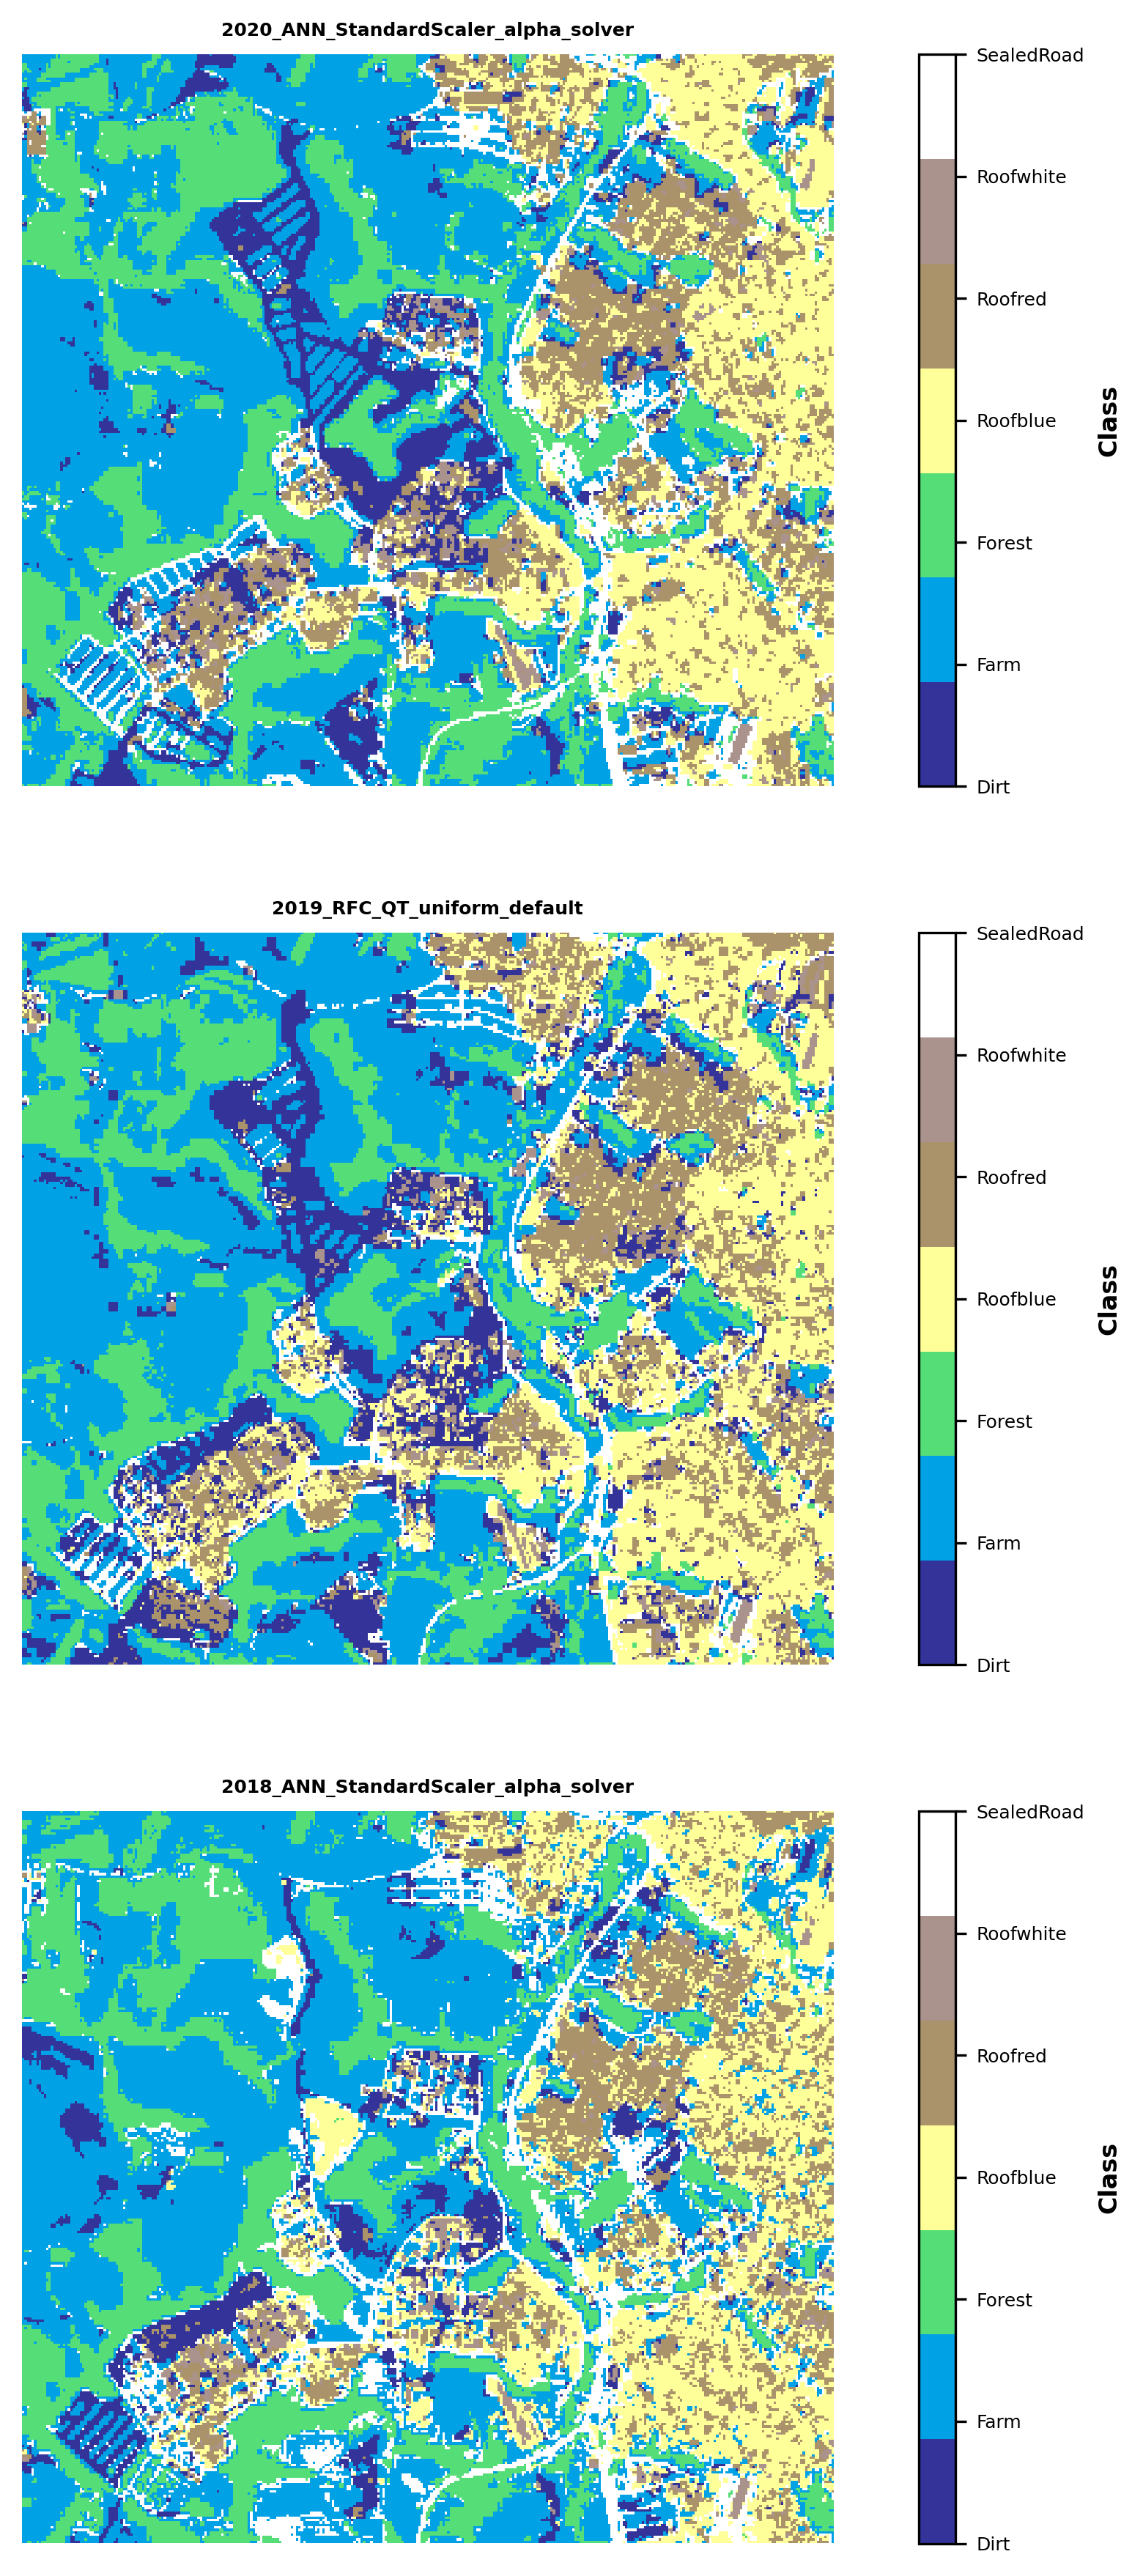

In [36]:
fig, axs = plt.subplots(3,1, figsize=(10,15))

# Define the label size of colorbar:
label_size = 6
mpl.rcParams['ytick.labelsize'] = label_size 

# 2020 plot:
predict_plot = axs[0].imshow(y_pred_img_01, cmap=plt.cm.get_cmap('terrain', len(labels)))
cbar1 = fig.colorbar(predict_plot, ax=axs[0])
cbar1.set_label(label='Class', fontsize=8, weight='bold')
cbar1.set_ticks(np.arange(0, len(labels)))
cbar1.set_ticklabels(labels)
axs[0].set_title(classifier_name_01, fontsize=6, weight='bold')
axs[0].set_axis_off()

# 2019 plot:
predict_plot = axs[1].imshow(y_pred_img_02, cmap=plt.cm.get_cmap('terrain', len(labels)))
cbar = fig.colorbar(predict_plot, ax=axs[1])
cbar.set_label(label='Class', fontsize=8, weight='bold')
cbar.set_ticks(np.arange(0, len(labels)))
cbar.set_ticklabels(labels)
axs[1].set_title(classifier_name_02, fontsize=6, weight='bold')
axs[1].set_axis_off()

# 2018 plot:
predict_plot = axs[2].imshow(y_pred_img_03, cmap=plt.cm.get_cmap('terrain', len(labels)))
cbar2 = fig.colorbar(predict_plot, ax=axs[2])
cbar2.set_label(label='Class', fontsize=8, weight='bold')
cbar2.set_ticks(np.arange(0, len(labels)))
cbar2.set_ticklabels(labels)
axs[2].set_title(classifier_name_03, fontsize=6, weight='bold')
axs[2].set_axis_off()

Plot RGB images for the 2018, 2019 and 2020 sentinel data in order to compare with the classification results:

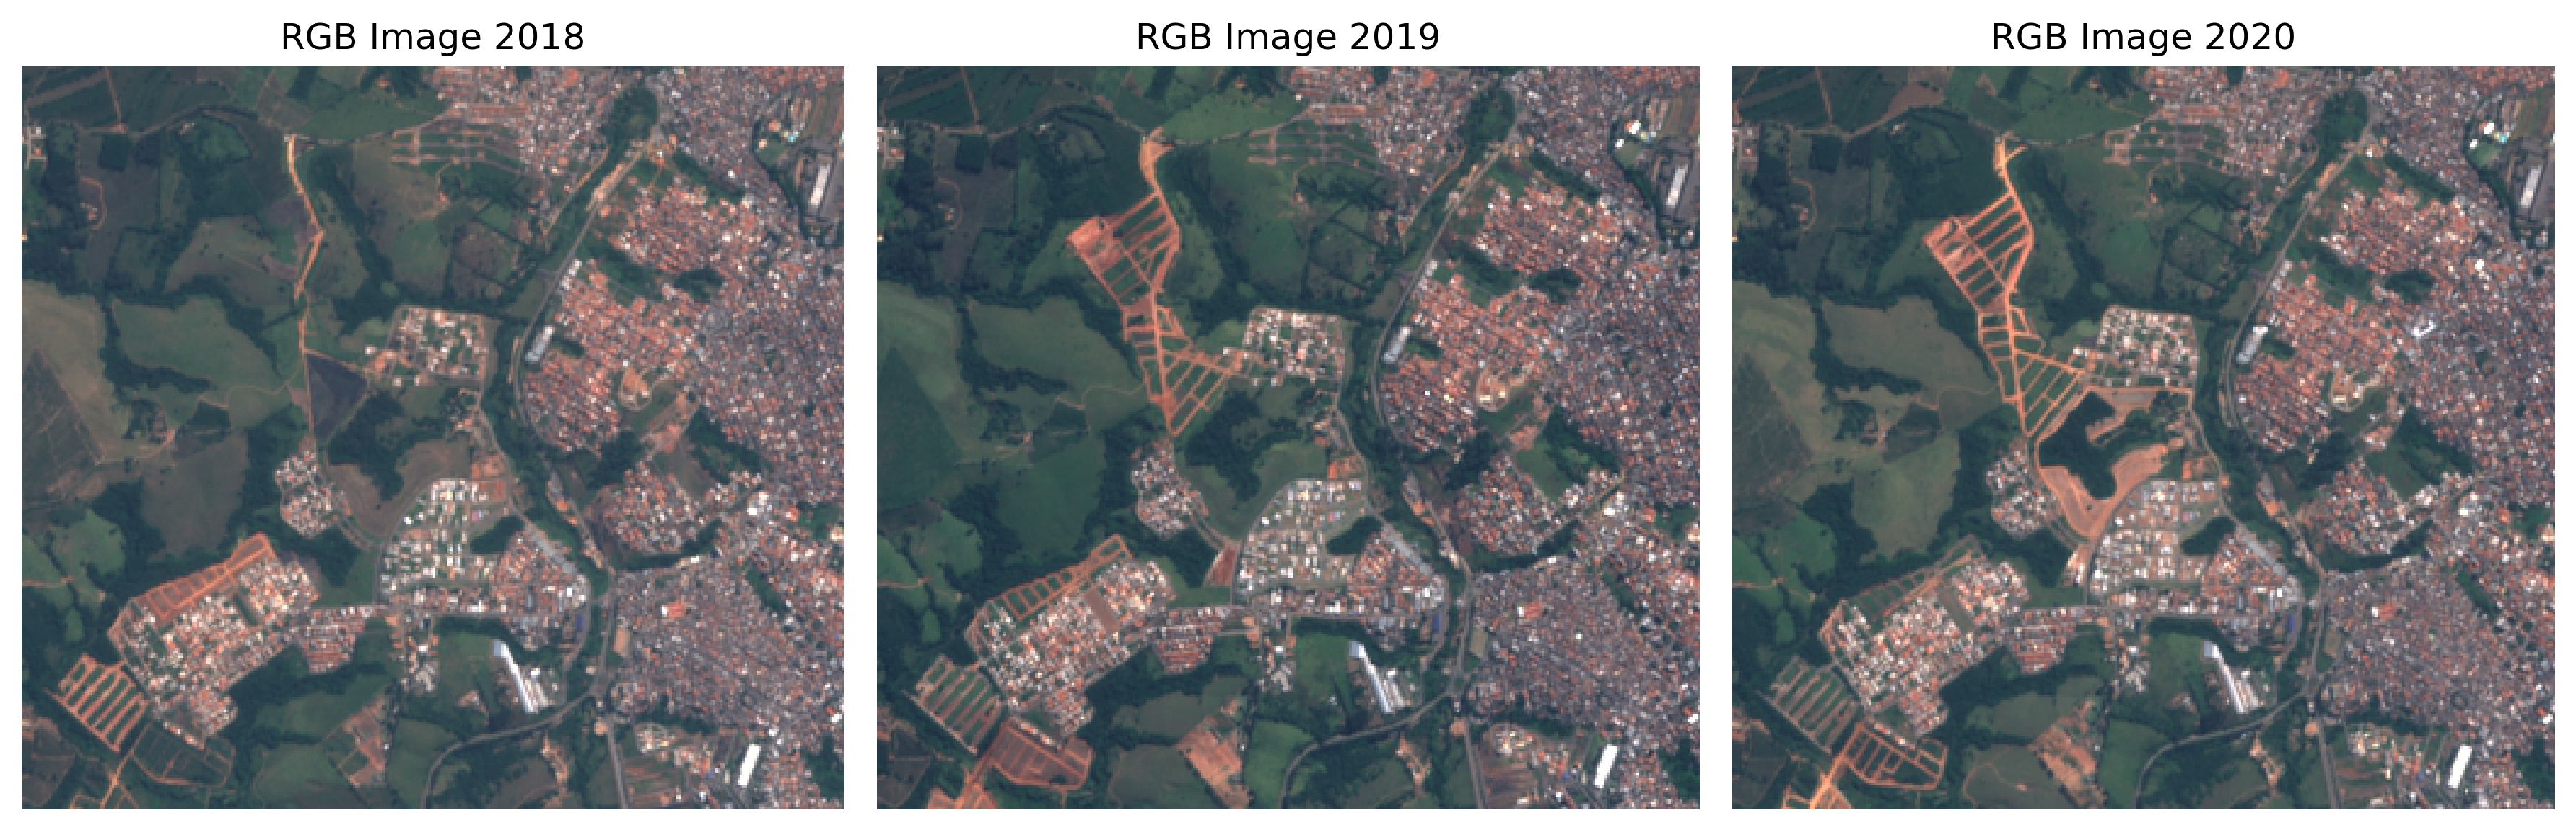

In [40]:
mpl.rcParams['figure.dpi']= 300

img_2020 = mpimg.imread(rgb_fp_01)
img_2019 = mpimg.imread(rgb_fp_02)
img_2018 = mpimg.imread(rgb_fp_03)

fig, axs = plt.subplots(1,3)

# 2018
axs[0].imshow(img_2018)
axs[0].set_title('RGB Image 2018', fontsize=12)
axs[0].set_axis_off()
# 2019
axs[1].imshow(img_2019)
axs[1].set_title('RGB Image 2019', fontsize=12)
axs[1].set_axis_off()
# 2020
axs[2].imshow(img_2020)
axs[2].set_title('RGB Image 2020', fontsize=12)
axs[2].set_axis_off()

plt.tight_layout()

**(e)** *Compare and discuss the results of your predicted land use labels in the three different scenes. Were there any problems? Do you note any clear land cover changes? Is this real change or error in the model?*

Comparing the classifications for the three different years from  2018-2020 the main issue was that some of the farm areas were missclassified as 'roofblue' and 'sealedRoad', however it was not a big issue since it was only on a really small area. There are clear changes in the land cover in the left side of the images, changes caused by urban development. We can observe that in 2018 this area was mostly forest and farm, but in 2019 and 2020 it got replaced by dirt roads, this happened once these areas started being developed and sold as lots for urban purposes. The changes are real, this is my hometown in Brazil and the city has been growing towards this region for the last couple of years. Also, we can observe the changes in the 8bit RGB images of each year plotted with the classification above.  


---

**(f)** Using the EuroSAT RGB data, train a few CNNs with different architecture (at least two different architectures). Report their validation accuracy using a simple train-test split (or optionally, with a cross-validation loop). Optionally, try to regularize the best model to prevent overfitting (using, e.g., dropout layers, batchnormalization layers, etc.).

In [1]:
import tensorflow as tf
import keras

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 5)
mpl.rcParams['figure.dpi']= 300
import os
import numpy as np
import matplotlib.image as mpimg
import rasterio
from keras.optimizers import SGD, Adam
from sklearn.model_selection import train_test_split

Define the directory for 05_eurosat_rgb data and label names for each class considering that each folder corresponds to a class:

In [3]:
DATA_DIRECTORY = 'C:/Users/laris/Desktop/GEW-DAP05/lab5/05_eurosat_rgb'

label_names = os.listdir(DATA_DIRECTORY)

Used the EuroSAT labels with 1000 labels for each class, due to the fact that I am working on my personal laptop with limited specs.

In [4]:
labels = ['Forest', 'River', 'Highway', 'AnnualCrop', 'SeaLake', 'HerbaceousVegetation', 
          'Industrial', 'Residential', 'PermanentCrop', 'Pasture'] 

label_dict = dict(zip(labels, np.arange(len(labels), dtype=int)))
reverse_label_dict = dict(map(reversed, label_dict.items()))

# Function to create X and y for Eurosat labels:
def create_X_y(DATA_DIRECTORY):
    """
    DATA_DIRECTORY: string, either "05_eurosat_rgb" or "05_eurosat_all"
    """
    
    # label directories
    label_names = os.listdir(DATA_DIRECTORY)
    label_dirs = [DATA_DIRECTORY + '/' + label + '/' for label in label_names]

    # containers for images and labels
    X = []
    y = []

    for label_dir in label_dirs:
        
        #print(label_dir)
        
        fnames = os.listdir(label_dir)
        
        for fname in fnames:

            # extract label from file name
            label = fname.split('_')[0]
            yi = label_dict[label]
            y.append(yi)

            # read image
            if DATA_DIRECTORY == 'C:/Users/laris/Desktop/GEW-DAP05/lab5/05_eurosat_rgb':
                Xi = mpimg.imread(label_dir + fname)
            elif DATA_DIRECTORY == '05_eurosat_all':
                Xi = rasterio.open(label_dir + fname).read()
                Xi = np.moveaxis(Xi, 0, -1)
                # Xi = tiff.imread(label_dir + fname)
                
            X.append(Xi)

    X = np.asarray(X)
    y = np.asarray(y)
    # y = tf.keras.utils.to_categorical(y)
    
    return X, y

# Creating X and y using the defined function:
X, y = create_X_y('C:/Users/laris/Desktop/GEW-DAP05/lab5/05_eurosat_rgb')

Split the data into train/test, and rescale respectively:

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

X_train, X_test = X_train/255., X_test/255.

__ResNet__

Reshape y train and test in order to fit the ResNet model:

In [6]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

In [7]:
y_train = convert_to_one_hot(y_train, 10).T
y_test = convert_to_one_hot(y_test, 10).T

Define the base model using the current input shape:

In [8]:
base_model = keras.applications.resnet50.ResNet50(weights=None, include_top=False, input_shape=(64,64,3))

Add global average pooling layer, droupout layer and dense layer to the base model:

- model.summary was commented out to reduce the size of the final .pdf

In [9]:
x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.7)(x)
predictions = keras.layers.Dense(10, activation= 'softmax')(x)
model = keras.Model(inputs = base_model.input, outputs = predictions)
# model.summary()

Apply Adam optimizer with a learning rate of 0.001.

In [12]:
adam = Adam(lr=0.001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

Fit model:

- The cell bellow was cleared to reduce size of final .pdf

In [ ]:
%%time
history = model.fit(X_train, y_train, epochs = 15, validation_data=(X_test, y_test))

Evaluate model with X and y test, obtaining the accuracy and loss for the model:

In [14]:
preds = model.evaluate(X_test, y_test)
print ('Loss = ' + str(preds[0]))
print ('Test Accuracy = ' + str(preds[1]))

63/63 [==============================] - 16s 249ms/step - loss: 1.0015 - accuracy: 0.7060
Loss = 1.0015305280685425
Test Accuracy = 0.7059999704360962


__LeNet-5__

Split data for train and test and rescale the X and y:

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)
X_train, X_test = X_train/255., X_test/255.

Add convolutional layers, Average pooling and dense layers to the LeNet-5 architecture, the model summary was commented out in order to reduce the size of the final .pdf.

In [26]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(5, 5), activation='relu', input_shape=(64, 64, 3)))
model.add(tf.keras.layers.AveragePooling2D((2,2)))
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
model.add(tf.keras.layers.AveragePooling2D((2,2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=120, activation='relu'))
model.add(tf.keras.layers.Dense(units=84, activation='relu'))
model.add(tf.keras.layers.Dense(units=10, activation = 'softmax'))
# model.summary()

Choose optimizer, loss function, score metric and compile model:

- The cell bellow was cleared to reduce size of final .pdf

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Fit model:
history = model.fit(X_train, y_train, epochs=15, validation_data=(X_test, y_test))

Evaluate model using the X and y test data, obtaining the accuracy and loss values:

In [28]:
model.evaluate(X_test, y_test, verbose=2)


63/63 - 1s - loss: 1.9275 - accuracy: 0.5330


[1.9274717569351196, 0.5329999923706055]

__Regularize CNN__

Since the models attempted above were not performing as good as expected on the Eurosat labels, I attempeted regularizing a CNN to achieve a higher accuracy.

Split X and y for train and test and rescale the values:

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)
X_train, X_test = X_train/255., X_test/255.

Build a sequential model using 3 CCP layers with increasing values 16, 32, 64. Added stride of 2 to the maxpooling layer and a dropout layer on the end:

In [31]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 3)),
    tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=2),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=2),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(.6),
    tf.keras.layers.Dense(10)
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 62, 62, 16)        448       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 60, 60, 16)        2320      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 30, 30, 16)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 28, 28, 32)        4640      
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 26, 26, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 11, 11, 64)       

*Choose optimizer, loss function, score metric and compile model:*

In [33]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

- The cell bellow was cleared to reduce size of final .pdf

In [ ]:
%%time

# Fit model
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test))

Evaluate model using the X and y test data, obtaining the accuracy and loss values:

In [36]:
evaluation = model.evaluate(X_test, y_test, verbose=2)


63/63 - 1s - loss: 0.6452 - accuracy: 0.8305


*This regularized CNN was the model with best scores, if compared to LeNet-5 and ResNet architectures attempted previously. The regularized CNN had an accuracy of 83%, whereas LeNet-5 had an accuracy of 53% and ResNet had an accuracy of 70%. I had some issues trying to determine what would be the ideal number of epochs for each architecture, and therefore attempted running each one with different epochs until the results were satisfactory.*

---

**(g)** Pass each of the Sentinel scenes (tiled into 64*64 pixel images) through the best CNN model to get predictions. Plot at least 20 tiles from each scene showing the same geographic area in each tile.

File path to the rgb images for visualization and reading each image for 2018, 2019 and 2020:

In [66]:
rgb_fp_01 =  '01_sentinel_varginha_2020_rgb_8bit.jpg'
rgb_fp_02 =  '02_sentinel_varginha_2019_rgb_8bit.jpg'
rgb_fp_03 =  '03_sentinel_varginha_2018_rgb_8bit.jpg'

img_2020 = mpimg.imread(rgb_fp_01)
img_2019 = mpimg.imread(rgb_fp_02)
img_2018 = mpimg.imread(rgb_fp_03)

Rescale the images for each year:

In [67]:
img_2020 = img_2020 / 255.
img_2019 = img_2019 / 255.
img_2018 = img_2018 / 255.

Set the window size (64 * 64) to be the same as EuroSAT, and create an empty tile array for each year:

In [68]:
windowSize = 64
tiles_2018 = []
tiles_2019 = []
tiles_2020 = []

Loop over rows and columns in full array, striding by the window size and storing it on a list. And recast tile list as numpy array. this process was applied for each year individually:

2018:

In [69]:
for row in range(0, img_2018.shape[0], windowSize):
    for col in range(0, img_2018.shape[1], windowSize):
        img_2018_tile = img_2018[row : row + windowSize, col : col + windowSize, :]
        if img_2018_tile.shape[0] == windowSize and img_2018_tile.shape[1] == windowSize:
            tiles_2018.append(img_2018_tile)

tiles_2018 = np.asarray(tiles_2018)

2019:

In [70]:
for row in range(0, img_2019.shape[0], windowSize):
    for col in range(0, img_2019.shape[1], windowSize):
        img_2019_tile = img_2019[row : row + windowSize, col : col + windowSize, :]
        if img_2019_tile.shape[0] == windowSize and img_2019_tile.shape[1] == windowSize:
            tiles_2019.append(img_2019_tile)

tiles_2019 = np.asarray(tiles_2019)

*2020*

In [71]:
for row in range(0, img_2020.shape[0], windowSize):
    for col in range(0, img_2020.shape[1], windowSize):
        img_2020_tile = img_2020[row : row + windowSize, col : col + windowSize, :]
        if img_2020_tile.shape[0] == windowSize and img_2020_tile.shape[1] == windowSize:
            tiles_2020.append(img_2020_tile)

tiles_2020 = np.asarray(tiles_2020)

*Get 20 random tiles to predict using the trained CNN:*

In [72]:
idx = np.random.randint(len(tiles_2018), size=20)

*Predict tiles for 2018*

In [73]:
y_pred_logit_tiles_2018 = model(tiles_2018[idx].astype('float32')).numpy()
y_pred_tiles_2018 = tf.nn.softmax(y_pred_logit_tiles_2018).numpy()

*Predict tiles for 2019*

In [74]:
y_pred_logit_tiles_2019 = model(tiles_2019[idx].astype('float32')).numpy()
y_pred_tiles_2019 = tf.nn.softmax(y_pred_logit_tiles_2019).numpy()

*Predict tiles for 2020*

In [75]:
y_pred_logit_tiles_2020 = model(tiles_2020[idx].astype('float32')).numpy()
y_pred_tiles_2020 = tf.nn.softmax(y_pred_logit_tiles_2020).numpy()

*Plot 2018 the results to visualize predictions for each tile*

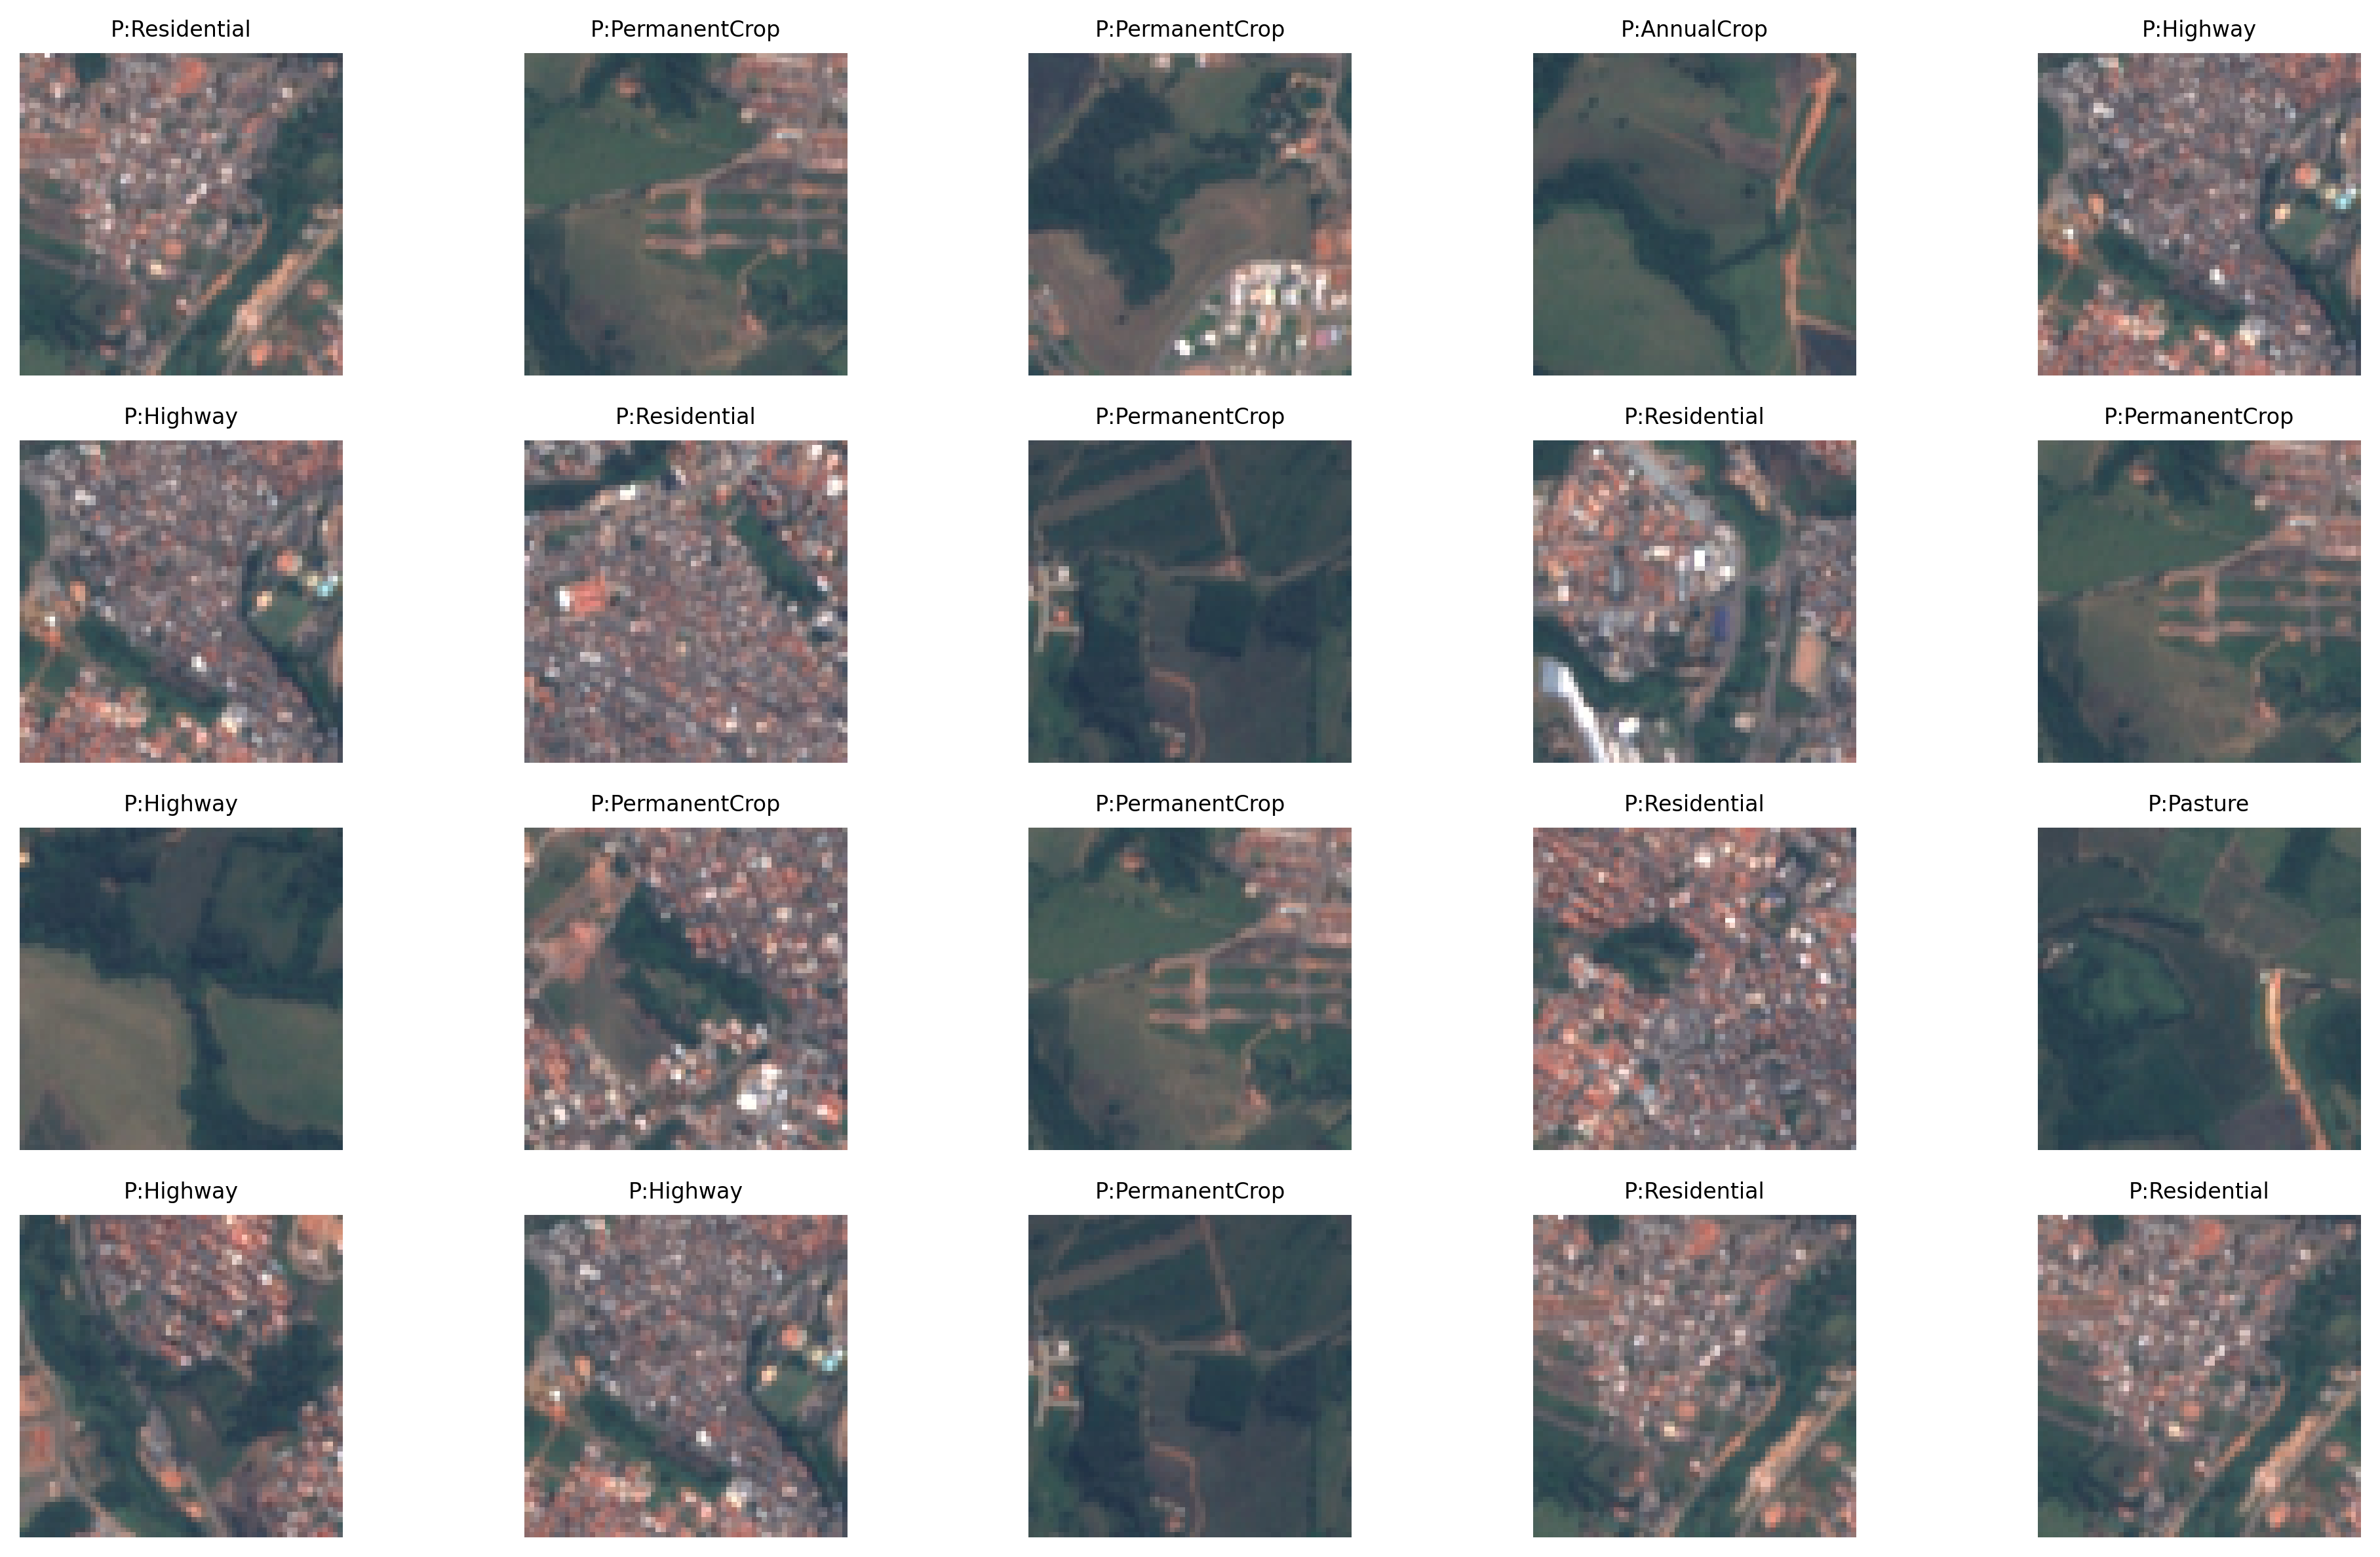

In [82]:
fig, axs = plt.subplots(4, 5, figsize=(16, 10))
for tile_i, y_pred_i, ax in zip(tiles_2018[idx], y_pred_tiles_2018, axs.flatten()):
    ax.imshow(tile_i)
    pred_label = reverse_label_dict[y_pred_i.argmax()]
    ax.set_title('P:{}'.format(pred_label), fontsize=8)
    ax.set_axis_off()
    

*Plot 2019 the results to visualize predictions for each tile*

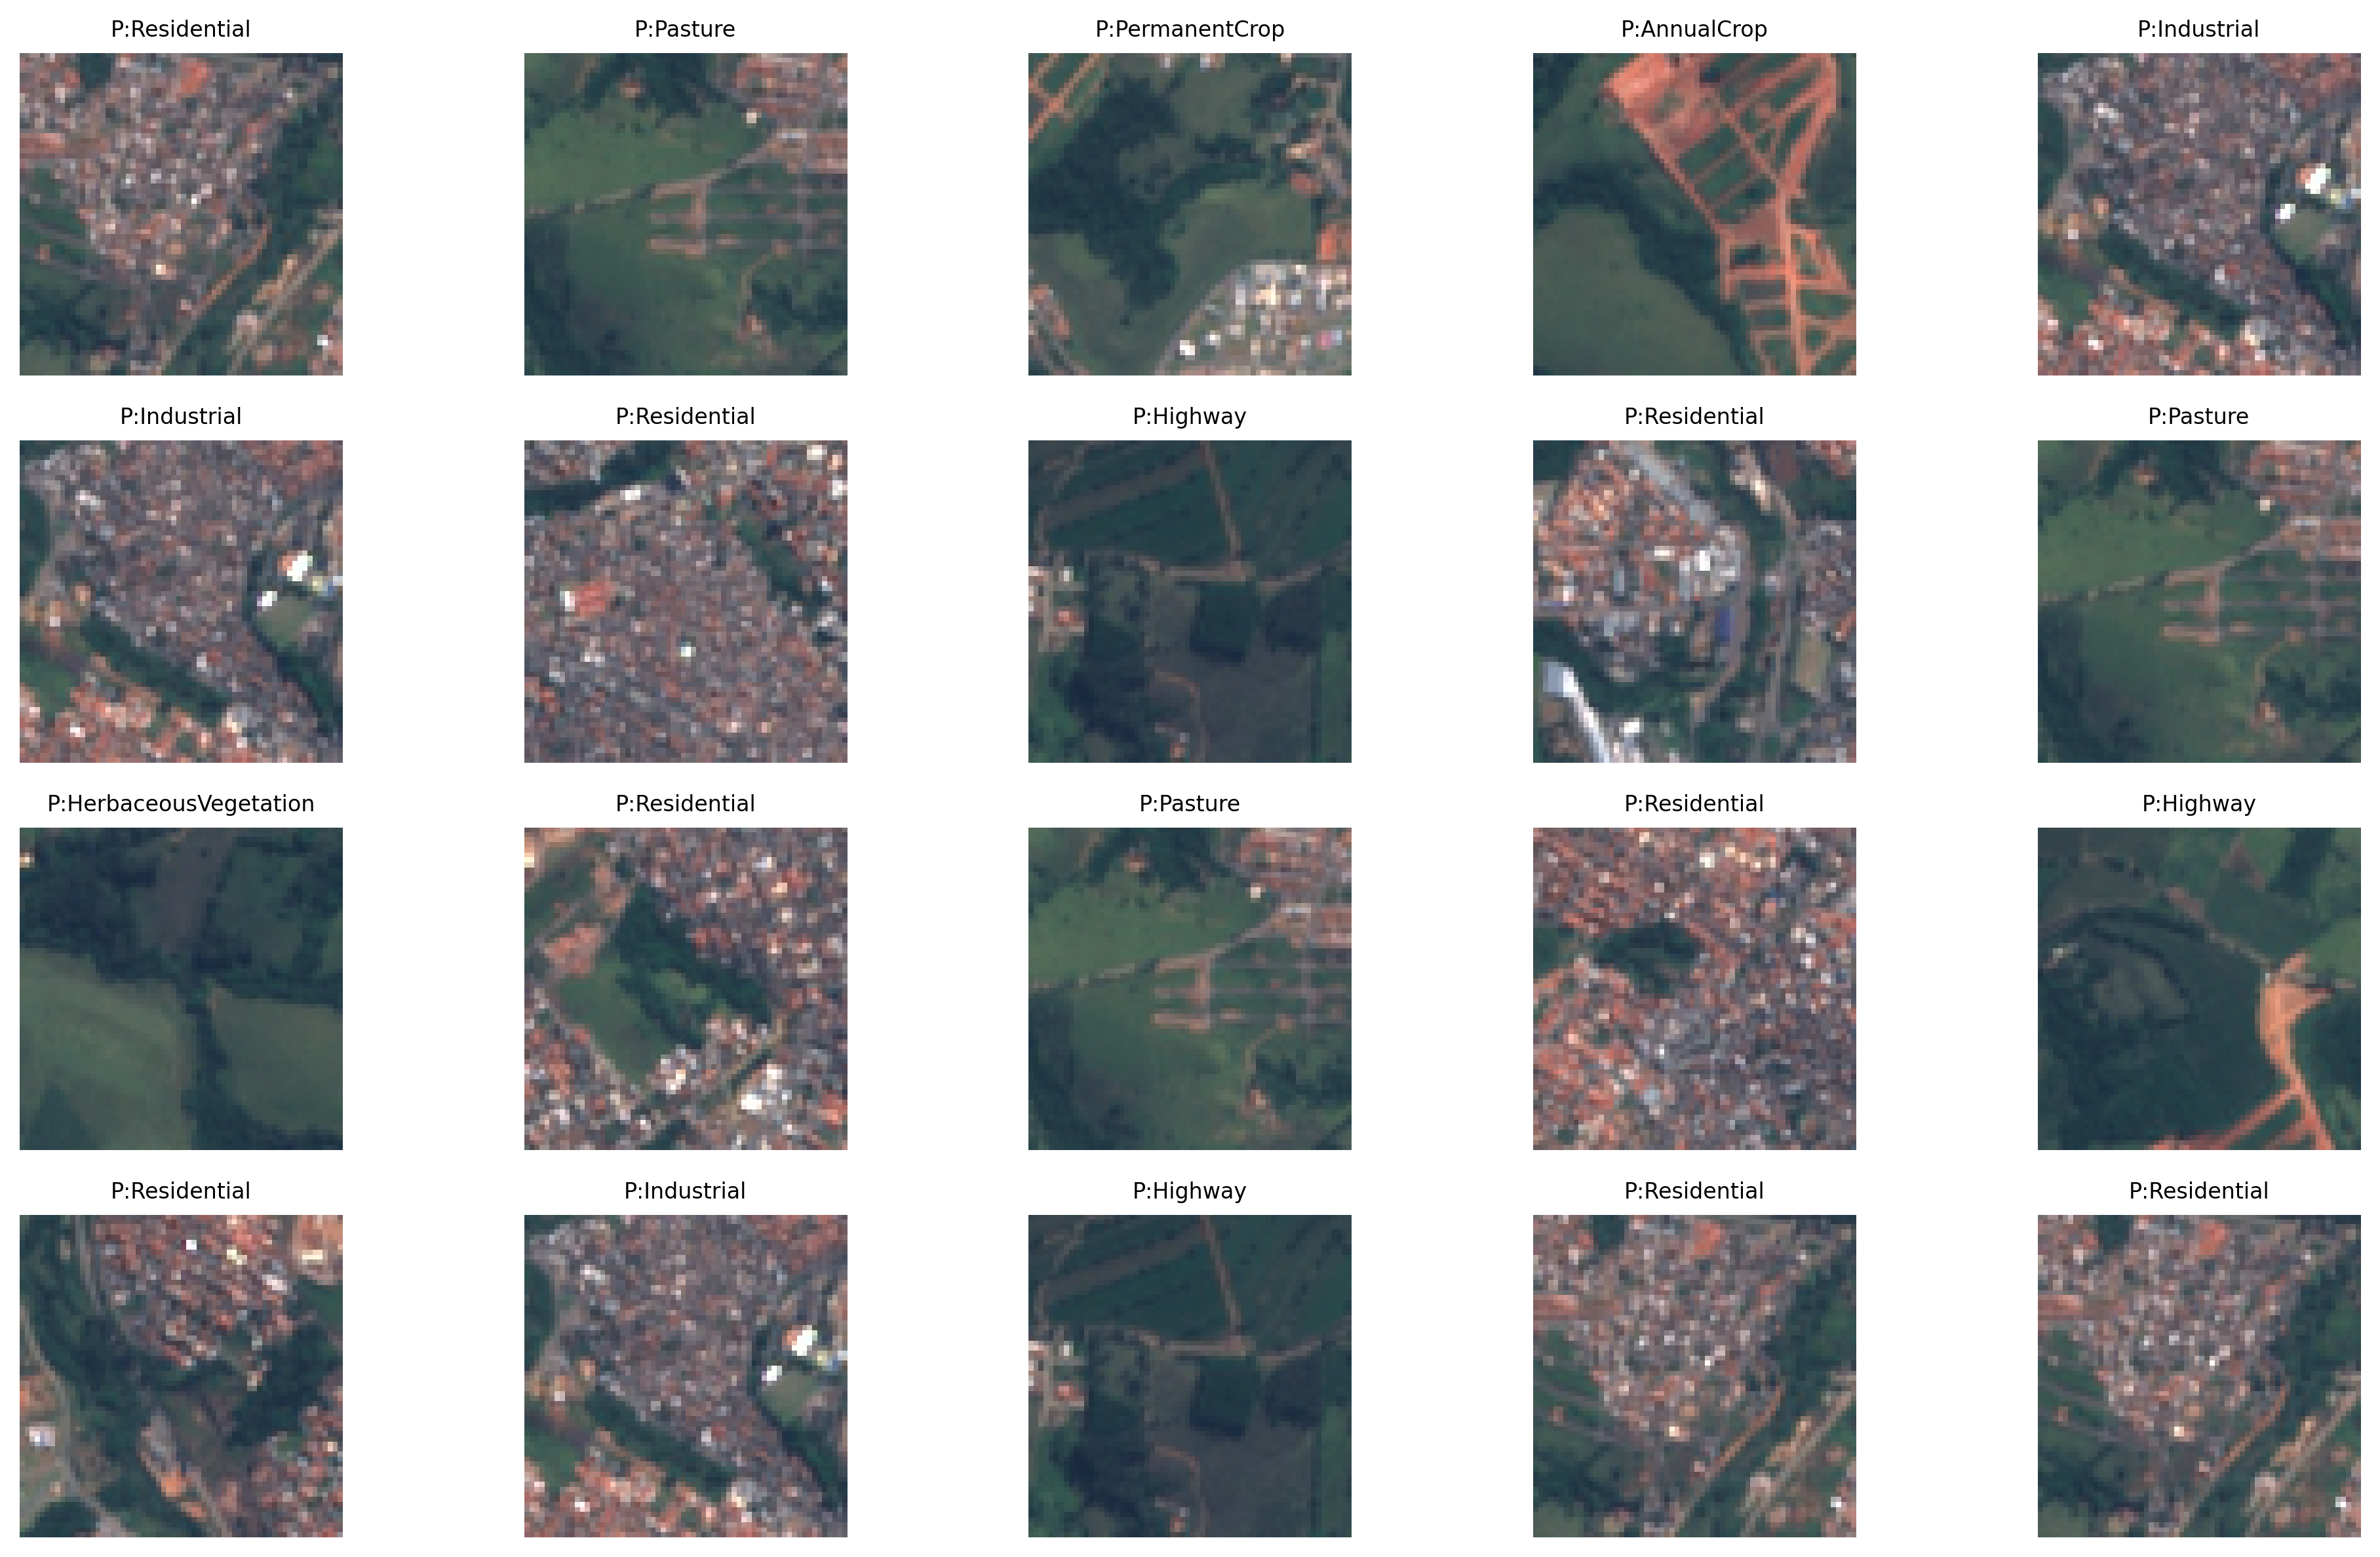

In [83]:
fig, axs = plt.subplots(4, 5, figsize=(16, 10))
for tile_i, y_pred_i, ax in zip(tiles_2019[idx], y_pred_tiles_2019, axs.flatten()):
    ax.imshow(tile_i)
    pred_label = reverse_label_dict[y_pred_i.argmax()]
    ax.set_title('P:{}'.format(pred_label), fontsize=8)
    ax.set_axis_off()

*Plot 2020 the results to visualize predictions for each tile*

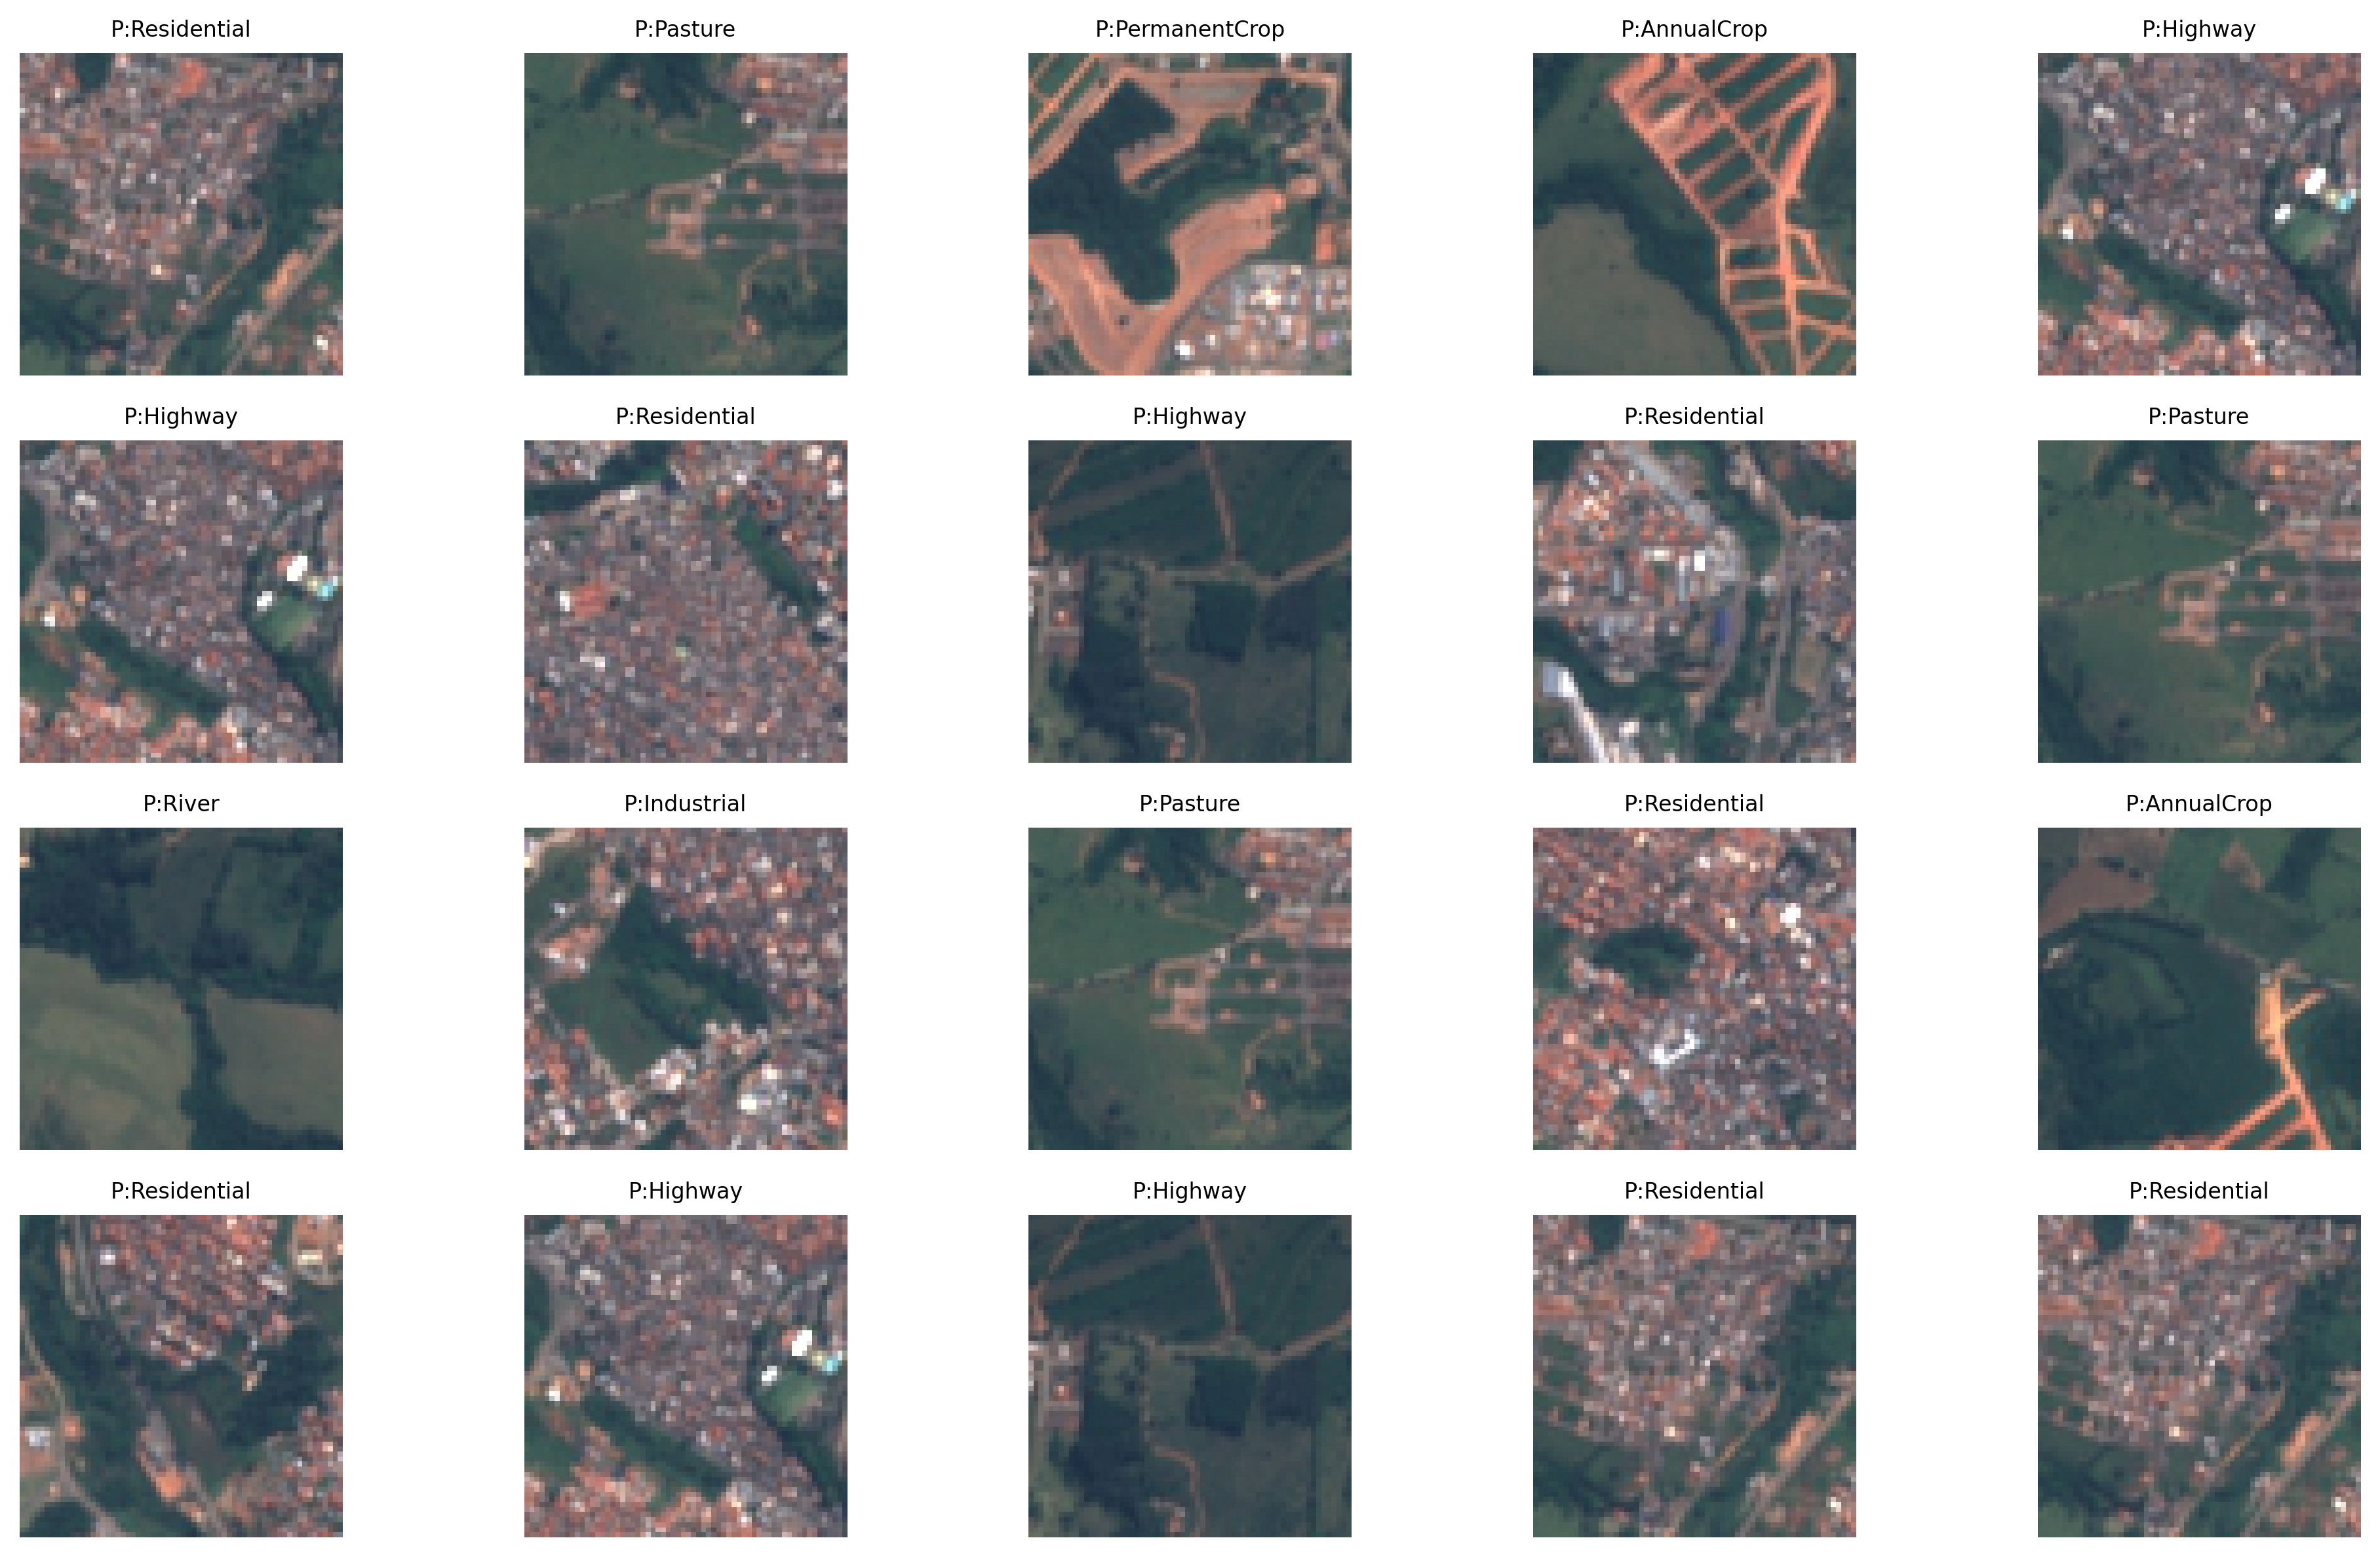

In [84]:
fig, axs = plt.subplots(4, 5, figsize=(16, 10))
for tile_i, y_pred_i, ax in zip(tiles_2020[idx], y_pred_tiles_2020, axs.flatten()):
    ax.imshow(tile_i)
    pred_label = reverse_label_dict[y_pred_i.argmax()]
    ax.set_title('P:{}'.format(pred_label), fontsize=8)
    ax.set_axis_off()

**(h)** Compare and discuss the predictions on these tiles. Do the results look reasonable? What are the problems that you see? How could the predictions be improved and what are the limitations of this approach?

*The classes which were best identified were pasture, highways and residential. Some of the residential class tiles were misclassified as industrial, and the new lots designated for urban development were misclassified as Annual crop and Permanent crop. That being said, the classifications performed quite well considering that the urban region of a medium size town in Brazil can look fairly different from the landscapes around Europe. The misclassification of the new urban lots with crops are not that unusual since even someone who does not know the town could confuse these two classes.*

*If we compare each tile of each year we can notice this differences:* 

>2018 vs 2019: 12/20 - Between 2018 and 2019 there were 12 different identified tiles.

>2018 vs 2020: 9/20 - Between 2018 and 2020 there were 9 different identified tiles.

>2019 vs 2020: 6/20 - Between 2019 and 2020 there were 6 different identifies tiles.

*As can observe this differences are not necessarily due to changes in the landscape throughout the years. Whilst there were differences between the three images those are not correlated to the actual differences in the classes.*

*In conclusion the Eurosat labels did not classify the tiles as well as expected. The difference between European cities and Brazilian cities were more significant than expected. There were too many classes representing vegetation on the Eurosat labels, and this area did not have many agricultural land since its located so close to the main city area.*  

**(i)** Compare and discuss the results of the pixel versus the image classification on the Sentinel time series. Which method provided the best overall results and what were the limitations of each?

*Considering the overall results of both methods it is very clear that the pixel classification performed better than the image classification. The image classification did not perform very well due to the fact that the classes of the EuroSAT labels were not very representative of the selected area in Brazil, considering it was mostly an urban area with some forests and small farm areas and the EuroSAT labels had many more classes for vegetation. The pixel classification on the other hand had great results, since the labels used to perform the classification were exactly those present in the image.*

*That being said, if using available labels such as EuroSAT it is important to know the region and if the labels would actually describe well that region in order to obtain good image classification results. One of the limitations of using pixel classification was that even though the results were great, there was a lot more time invested on the process of creating labels for each image. Whereas the image classification might be a lot faster since it does not require manually labelling classes. If I had a chance to do this same project one more time, a good approach would have been to try and match the EuroSAT labels on the selected region in order to be able to perform a more effective comparison.*

---